In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch.nn as nn
import torch.nn.functional as F

In [2]:
## Training and Testing files
df_train = pd.read_csv('/mnt/suhas/OCR/nougat/config_s/CAMS/CAMS_newdata_glove/dataset_train.csv', encoding = "ISO-8859-1")
df_test = pd.read_csv('/mnt/suhas/OCR/nougat/config_s/CAMS/CAMS_newdata_glove/dataset_test.csv', encoding = "ISO-8859-1")
df_val = pd.read_csv('/mnt/suhas/OCR/nougat/config_s/CAMS/CAMS_newdata_glove/dataset_val.csv', encoding = "ISO-8859-1")


#training data
# df_train = pd.DataFrame(read_file, columns= ['selftext','ANNOTATIONS'])
df_train = df_train.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_train = df_train.convert_dtypes()

#testing data
# df_test = pd.DataFrame(read_file1,columns= ['selftext','ANNOTATIONS'])#### 
df_test = df_test.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_test = df_test.convert_dtypes()

#validation data
# df_val = pd.DataFrame(read_file2,columns= ['selftext','ANNOTATIONS'])####
df_val = df_val.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_val = df_val.convert_dtypes()

In [4]:


#training data
# df_train = pd.DataFrame(read_file, columns= ['selftext','ANNOTATIONS'])
df_train = df_train.rename(columns={'ï»¿text': 'text','category':'label'})
df_train = df_train.convert_dtypes()

#testing data
# df_test = pd.DataFrame(read_file1,columns= ['selftext','ANNOTATIONS'])#### 
df_test = df_test.rename(columns={'ï»¿text': 'text','category':'label'})
df_test = df_test.convert_dtypes()

#validation data
# df_val = pd.DataFrame(read_file2,columns= ['selftext','ANNOTATIONS'])####
df_val = df_val.rename(columns={'ï»¿text': 'text','category':'label'})
df_val = df_val.convert_dtypes()


In [6]:
df_test.columns

Index(['text', 'label', 'explanation'], dtype='object')

In [7]:
## some preprocessings due to wrong entries
df_test.drop(df_test[df_test.text=="emptypost"].index, inplace=True)
df_train.drop(df_train[df_train.text=="emptypost"].index, inplace=True)
df_test.drop(df_test[df_test.label==" "].index, inplace=True)
df_train.drop(df_train[df_train.label==" "].index, inplace=True)
df_test.dropna(inplace=True)
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)

In [8]:
frame = [df_test, df_train]
data =  pd.concat(frame)
data

,text,label,explanation
0,The company i work for is in a moving process ...,2,The company i work for is in a moving process ...
1,"I don't want to work, I don't want to travel, ...",2,"don't want to go back to college, learn new th..."
2,Hey. 16M here. IâÃÃ´m just a wee little hig...,2,"affecting my grades , could get away with doin..."
3,I tried to kill myself via partial suspension ...,3,"partial suspension hanging, headache"
4,IâÃÃ´m in my last year of compulsory school...,2,not allows to leave the school during break or...
...,...,...,...
4069,Its my first year in college and everytime i ...,2,first year in college and everytime i go i f...
4070,I think I get misinterpreted a lot. I don't fe...,1,"get misinterpreted, need validation, don't fee..."
4072,Okay so this is extremely embarrassing and I h...,2,"called lazy, out of employment, bullied by co-..."
4073,"Neither in 2016. Also not in 2015. 2014, wha...",5,instead of working on my art and bounding with...


In [9]:
from transformers import AutoTokenizer, AutoModel
import sys
import csv
import re
import string
import pickle
from collections import defaultdict
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from transformers import AdamW
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

[nltk_data] Downloading package stopwords to /home/ai-interns-
[nltk_data]     jan22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ai-interns-
[nltk_data]     jan22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
stop_words = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [11]:
def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)     
    text = text.replace('x', '')
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

In [13]:
# training data
df_train = df_train.reset_index(drop=True)
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'] = df_train['text'].str.replace('\d+', '')


# val data
df_val = df_val.reset_index(drop=True)
df_val['text'] = df_val['text'].apply(clean_text)
# df_val['text'] = df_val['text'].str.replace('\d+', '')

# testing data
df_test = df_test.reset_index(drop=True)
df_test['text'] = df_test['text'].apply(clean_text)
df_test['text'] = df_test['text'].str.replace('\d+', '')

In [15]:
train_text, train_labels = df_train['text'], df_train['label']
val_text, val_labels = df_val['text'], df_val['label']
test_text, test_labels = df_test['text'], df_test['label']

In [18]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [19]:
# Global Variables

max_nb_words = 60000
max_features = 10543
maxlen = 350
emb_dim = 100
batch_size = 8
epochs  = 15


In [20]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = maxlen,
    pad_to_max_length = True,
    truncation = True,
    return_token_type_ids =False,
)

/mnt/suhas/packages/miniconda3/envs/parseq/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = maxlen,
    pad_to_max_length = True,
    truncation = True,
    return_token_type_ids =False,
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [22]:
### Creating Tensors from the train, validation and test sequences ###
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Defining dataloaders

In [23]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
trainloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask,val_y)
val_sampler = SequentialSampler(val_data)
valloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size,shuffle=False, drop_last=True)

In [24]:
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
testloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size,shuffle=False, drop_last=True)

In [25]:
len(trainloader), len(valloader), len(testloader)


(442, 140, 140)

In [56]:
import os
import requests
from zipfile import ZipFile

def download_glove(destination_folder="glove"):
    """
    Downloads GloVe embeddings from Stanford's website and extracts them.
    """
    glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    glove_zip_path = os.path.join(destination_folder, "glove.6B.zip")
    
    # Create destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)
    
    # Download GloVe zip file
    if not os.path.exists(glove_zip_path):
        print("Downloading GloVe embeddings...")
        response = requests.get(glove_url, stream=True)
        with open(glove_zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print("Downloaded GloVe embeddings.")
    else:
        print("GloVe zip file already exists.")
    
    # Extract GloVe zip file
    print("Extracting GloVe embeddings...")
    # with ZipFile(glove_zip_path, "r") as zip_ref:
    #     zip_ref.extractall(destination_folder)
    # print(f"GloVe embeddings extracted to {destination_folder}.")

# Call the function to download and extract GloVe
download_glove()


GloVe zip file already exists.
Extracting GloVe embeddings...


In [57]:
import torch
import torch.nn as nn
from transformers import RobertaModel, RobertaTokenizer
import numpy as np

# Define the custom Roberta model with a classification head
class RobertaWithGlove(nn.Module):
    def __init__(self, glove_embeddings):
        super(RobertaWithGlove, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        # Replace the word embeddings with GloVe
        with torch.no_grad():
            projection = nn.Linear(300, 768, bias=False)
            projected_glove = projection(glove_embeddings)
            self.roberta.embeddings.word_embeddings = nn.Embedding.from_pretrained(projected_glove)
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(768, 6)  # 6-class classification head

    def forward(self, sent_id, mask):
        roberta_out = self.roberta(sent_id, attention_mask=mask)
        pooled_out = roberta_out.pooler_output  # Use pooled output
        pooled_out = self.dropout(pooled_out)
        logits = self.fc(pooled_out)
        return logits

# Step 1: Load GloVe embeddings
def load_glove_embeddings(glove_file, vocab):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    
    embedding_dim = len(next(iter(embeddings_index.values())))
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
        else:
            # Use random initialization or zeros for words not found in GloVe
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    
    return torch.tensor(embedding_matrix, dtype=torch.float)

# Step 2: Load the tokenizer and map GloVe embeddings
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
glove_file = "/mnt/suhas/OCR/nougat/config_s/CAMS/glove/glove.6B.300d.txt"  # Path to your GloVe file
vocab = tokenizer.get_vocab()
glove_embeddings = load_glove_embeddings(glove_file, vocab)

# Step 3: Initialize the custom model
model = RobertaWithGlove(glove_embeddings)

# Check the model
print(model)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaWithGlove(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [58]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
import os
torch.cuda.empty_cache()
model = nn.DataParallel(model)
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
model.cuda()

DataParallel(
  (module): RobertaWithGlove(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=768, out_features=76

In [59]:
model

DataParallel(
  (module): RobertaWithGlove(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=768, out_features=76

## Model

In [30]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [31]:
import pandas as pd
import pickle
#import torch
#import transformers
#from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import sys
import csv
import re
from tqdm.notebook import tqdm
import sys
import csv
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup


In [32]:
train_labels

0       4
1       5
2       1
3       1
4       4
       ..
3530    2
3531    1
3532    2
3533    5
3534    5
Name: label, Length: 3535, dtype: Int64

In [33]:
trainLabels = torch.tensor(train_labels)
class_count = torch.bincount(trainLabels)
class_weights = 1.0 / class_count
class_weights /= torch.sum(class_weights)

lossfn = nn.CrossEntropyLoss(weight=class_weights)
lossfn.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.015)

In [34]:
# Global Variables

max_nb_words = 60000
max_features = 10543
maxlen = 350
emb_dim = 100
batch_size = 16
epochs  = 15

# setup 2

In [35]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Initialize metric tracking lists and best model tracking
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
best_val_loss = float('inf')
best_model_state = None

# Move the model to the specified device once before the training loop
model.to(device)

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_correct = 0
    epoch_train_total = 0

    progress_bar = tqdm(trainloader, desc="Training")
    for batch in progress_bar:
        inputs, mask, labels = batch
        inputs = inputs.squeeze().to(device)
        mask = mask.squeeze().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, mask)
        loss = lossfn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and correct predictions
        epoch_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, dim=1)
        epoch_train_correct += (preds == labels).sum().item()
        epoch_train_total += labels.size(0)

        # Update progress bar
        batch_loss = loss.item()
        batch_acc = (preds == labels).float().mean().item()
        progress_bar.set_postfix({'loss': f"{batch_loss:.4f}", 'acc': f"{batch_acc:.4f}"})

    # Calculate average loss and accuracy for the epoch
    avg_train_loss = epoch_train_loss / epoch_train_total+1e-25
    train_accuracy = epoch_train_correct / epoch_train_total+1e-25
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation Phase
    model.eval()
    epoch_val_loss = 0.0
    best_val_acc = 0.0
    epoch_val_correct = 0
    epoch_val_total = 0

    with torch.no_grad():
        for batch in tqdm(valloader, desc="Validation", leave=False):
            inputs, mask, labels = batch
            # print(f"Batch inputs shape: {inputs.shape}")  # Expected: [batch_size, seq_length]
            # print(f"Batch mask shape: {mask.shape}")      # Expected: [batch_size, seq_length]
            # print(f"Batch labels shape: {labels.shape}")  # Expected: [batch_size]
            
            inputs = inputs.squeeze().to(device)
            mask = mask.squeeze().to(device)
            labels = labels.to(device)

            outputs = model(inputs, mask)
            loss = lossfn(outputs, labels)

            # Accumulate loss and correct predictions
            epoch_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            epoch_val_correct += (preds == labels).sum().item()
            epoch_val_total += labels.size(0)

    # Calculate average loss and accuracy for validation
    avg_val_loss = epoch_val_loss / epoch_val_total
    val_accuracy = epoch_val_correct / epoch_val_total
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)
    
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Check if the current model is the best so far and save it
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'roberta_best_model_loss.pth')
        print("Best model saved.")

    # Check if the current model is the best so far and save it wrt to accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'roberta_best_model_acc.pth')
        print("Best model saved wrt accuracy.")

    #save the model
    torch.save(model.state_dict(), 'roberta_model_final.pth')

    # Optional: Step the scheduler if you're using one
    # scheduler.step(avg_val_loss)


Epoch 1/15


Training: 100%|██████████| 442/442 [02:31<00:00,  2.92it/s, loss=1.4417, acc=0.5714]


Train Loss: 1.6821, Train Accuracy: 0.3245


Validation Loss: 1.4997, Validation Accuracy: 0.4866
Best model saved.
Best model saved wrt accuracy.
Epoch 2/15


Training: 100%|██████████| 442/442 [02:14<00:00,  3.29it/s, loss=1.4793, acc=0.1429]


Train Loss: 1.4177, Train Accuracy: 0.4948


Validation Loss: 1.2944, Validation Accuracy: 0.5536
Best model saved.
Best model saved wrt accuracy.
Epoch 3/15


Training: 100%|██████████| 442/442 [02:10<00:00,  3.38it/s, loss=0.7139, acc=0.5714]


Train Loss: 1.2311, Train Accuracy: 0.5434


Validation Loss: 1.1988, Validation Accuracy: 0.5241
Best model saved.
Best model saved wrt accuracy.
Epoch 4/15


Training: 100%|██████████| 442/442 [02:12<00:00,  3.33it/s, loss=1.3375, acc=0.4286]


Train Loss: 1.0748, Train Accuracy: 0.5929


Validation Loss: 1.1499, Validation Accuracy: 0.5616
Best model saved.
Best model saved wrt accuracy.
Epoch 5/15


Training: 100%|██████████| 442/442 [02:10<00:00,  3.39it/s, loss=0.2929, acc=0.7143]


Train Loss: 0.8913, Train Accuracy: 0.6495


Validation Loss: 1.0866, Validation Accuracy: 0.6679
Best model saved.
Best model saved wrt accuracy.
Epoch 6/15


Training: 100%|██████████| 442/442 [02:07<00:00,  3.47it/s, loss=1.2818, acc=0.5714]


Train Loss: 0.7260, Train Accuracy: 0.7123


Validation Loss: 1.0390, Validation Accuracy: 0.6795
Best model saved.
Best model saved wrt accuracy.
Epoch 7/15


Training: 100%|██████████| 442/442 [02:07<00:00,  3.48it/s, loss=0.4223, acc=0.8571]


Train Loss: 0.5639, Train Accuracy: 0.7813


Validation Loss: 1.0461, Validation Accuracy: 0.7036
Best model saved wrt accuracy.
Epoch 8/15


Training: 100%|██████████| 442/442 [02:07<00:00,  3.47it/s, loss=1.9688, acc=0.4286]


Train Loss: 0.4258, Train Accuracy: 0.8255


Validation Loss: 1.1156, Validation Accuracy: 0.6964
Best model saved wrt accuracy.
Epoch 9/15


Training: 100%|██████████| 442/442 [02:13<00:00,  3.32it/s, loss=0.5161, acc=0.8571]


Train Loss: 0.3715, Train Accuracy: 0.8489


Validation Loss: 1.1708, Validation Accuracy: 0.7214
Best model saved wrt accuracy.
Epoch 10/15


Training: 100%|██████████| 442/442 [02:12<00:00,  3.33it/s, loss=1.5027, acc=0.8571]


Train Loss: 0.3306, Train Accuracy: 0.8710


Validation Loss: 1.1807, Validation Accuracy: 0.7045
Best model saved wrt accuracy.
Epoch 11/15


Training:  11%|█         | 47/442 [00:13<01:53,  3.47it/s, loss=0.0530, acc=1.0000]


KeyboardInterrupt: 

In [42]:
epochs = list(range(1, 10 + 1))

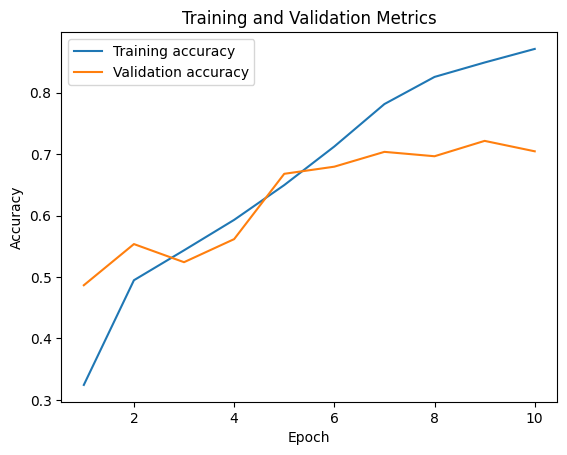

In [43]:
plt.plot(epochs, train_acc_list, label='Training accuracy')
plt.plot(epochs, val_acc_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

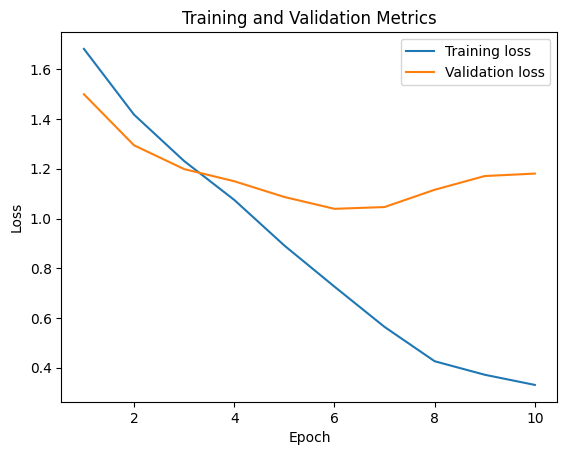

In [44]:
plt.plot(epochs, train_loss_list, label='Training loss')
plt.plot(epochs, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

## Evaluation

In [45]:
def compute_metrics(preds, labels):
    labels = labels
    preds = preds
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [46]:
model.eval()

test_predictions = []
test_labels = []
with torch.no_grad():
  for batch in testloader:
    inputs, mask, labels = batch
    inputs = inputs.squeeze().to(device)
    mask = mask.squeeze().to(device)
    labels = labels.to(device)
    outputs = model(inputs, mask)
    outputs.to(device)
    loss = lossfn(outputs, labels)
    logits = outputs
    test_predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    test_labels.extend(labels.cpu().numpy().tolist())

test_acc = accuracy_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print('Test accuracy:', test_acc)
print('Test F1 score:', test_f1)

Test accuracy: 0.7883928571428571
Test F1 score: 0.7901579928781907


In [47]:
compute_metrics(test_predictions, test_labels)

{'accuracy': 0.7883928571428571,
 'f1': array([0.62222222, 0.83657588, 0.82178218, 0.82696629, 0.75912409,
        0.70308789]),
 'precision': array([0.66666667, 0.91880342, 0.8556701 , 0.7965368 , 0.70588235,
        0.67579909]),
 'recall': array([0.58333333, 0.76785714, 0.79047619, 0.85981308, 0.82105263,
        0.73267327])}

In [45]:
print(classification_report(test_labels, test_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7778    0.5833    0.6667        24
           1     0.9412    0.8000    0.8649       300
           2     0.9209    0.8534    0.8859       232
           3     0.8814    0.8595    0.8703       242
           4     0.8000    0.8113    0.8056       212
           5     0.6570    0.8529    0.7422       238

    accuracy                         0.8293      1248
   macro avg     0.8297    0.7934    0.8059      1248
weighted avg     0.8445    0.8293    0.8326      1248



In [53]:

state_dict = torch.load('best_model.pth') #should also save last point ???

# Remove "module." prefix
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # Remove "module."
    new_state_dict[new_key] = v

# Load the modified state_dict
loaded = Roberta()
loaded.load_state_dict(new_state_dict)
loaded.to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Roberta(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [54]:
loaded.eval()

test_predictions = []
test_labels = []
with torch.no_grad():
  for batch in testloader:
    inputs, mask, labels = batch
    inputs = inputs.squeeze().to(device)
    mask = mask.squeeze().to(device)
    labels = labels.to(device)
    outputs = loaded(inputs, mask)
    outputs.to(device)
    loss = lossfn(outputs, labels)
    logits = outputs
    test_predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    test_labels.extend(labels.cpu().numpy().tolist())

test_acc = accuracy_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print('Test accuracy:', test_acc)
print('Test F1 score:', test_f1)

Test accuracy: 0.6883928571428571
Test F1 score: 0.6915185005257499


In [55]:
print(classification_report(test_labels, test_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.4375    0.5833    0.5000        24
           1     0.7826    0.6429    0.7059       280
           2     0.8241    0.7810    0.8020       210
           3     0.6967    0.7944    0.7424       214
           4     0.6954    0.6368    0.6648       190
           5     0.5062    0.6040    0.5508       202

    accuracy                         0.6884      1120
   macro avg     0.6571    0.6737    0.6610      1120
weighted avg     0.7019    0.6884    0.6915      1120

